# Stanford Stats 191

## Introduction

This is a re-creation of the Stanford Stats 191 course (see https://web.stanford.edu/class/stats191/), using Python eco-system tools, instead of R. This is lecture "Interactions and qualitative variables"

## Initial Notebook Setup

```watermark ``` documents the current Python and package environment, ```black``` is my preferred Python formatter

In [26]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [27]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [28]:
%matplotlib inline

In [69]:
import pandas as pd
import numpy as np
import seaborn as sn

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
import statsmodels.api as sm

from patsy import dmatrices

import warnings

-----
## Contrived Dataset

Before I started the STATS191, I decided to create a dataset with strong interaction effects, to see how OLS and ```statsmodels``` behaved

Set up our data grid (in ```x``` and ```y```)

In [30]:
n_data = 50
x_grid = np.linspace(0, 10, n_data)
y_grid = np.linspace(0, 10, n_data)

z = np.zeros((n_data, n_data))

beta = [2, 5, 8, 4]

Compute our response to the input ```x``` and ```y```

In [31]:
for i in range(len(x_grid)):  # run over all x
    for j in range(len(y_grid)):  # run over all y
        x = x_grid[i]
        y = y_grid[j]
        z[i, j] = (
            beta[0]
            + x * beta[1]
            + y * beta[2]
            + x * y * beta[3]
        )
    # end for
# end for

Plot the surface we computed

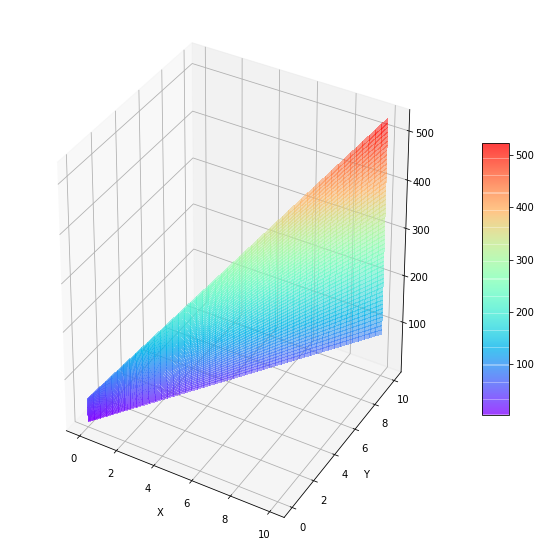

In [32]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface.
surf = ax.plot_surface(
    x_grid,
    y_grid,
    z,
    linewidth=5,
    antialiased=False,
    cmap='rainbow',
    alpha=0.5,
)

ax.set_xlabel('X')
ax.set_ylabel('Y')

fig.colorbar(surf, shrink=0.5, aspect=10)

I find it helps visualize a 3D surface if contour lines are added

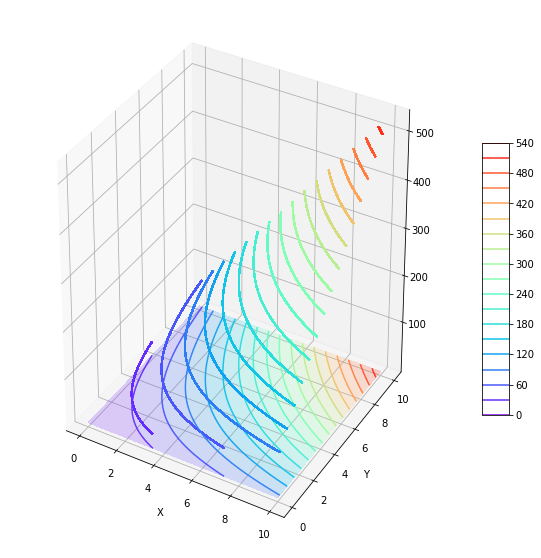

In [33]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface.
surf = ax.contour(
    x_grid,
    y_grid,
    z,
    antialiased=False,
    cmap='rainbow',
    levels=20,
)

z_offset = 0
ax.contour(
    x_grid,
    y_grid,
    z,
    zdir='z',
    offset=z_offset,
    cmap='rainbow',
    alpha=0.9,
    levels=20,
)

z_offset = 0
ax.contourf(
    x_grid,
    y_grid,
    z,
    zdir='z',
    offset=z_offset,
    cmap='rainbow',
    alpha=0.2,
    levels=20,
)

ax.set_xlabel('X')
ax.set_ylabel('Y')

fig.colorbar(surf, shrink=0.5, aspect=10)

A wireframe visualization is less useful

Text(0.5, 0, 'Y')

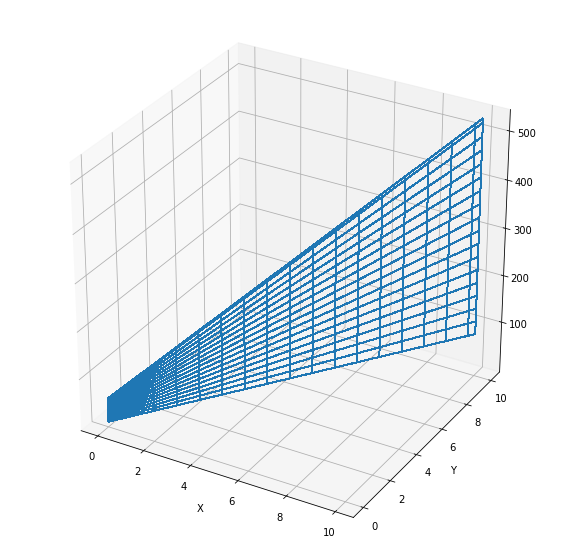

In [34]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface.
surf = ax.plot_wireframe(
    x_grid,
    y_grid,
    z,
    linewidth=1,
    antialiased=False,
    cmap='rainbow',
    rcount=20,
    ccount=20,
)

ax.set_xlabel('X')
ax.set_ylabel('Y')

### Add Noise, and Fit Model

In [35]:
n_points = n_data * n_data
z_points = np.zeros(n_points)
x_points = np.zeros(n_points)
y_points = np.zeros(n_points)

sigma = 2
error = np.random.normal(0, 1, n_points) * sigma


for i in range(len(x_grid)):  # run over all intercepts
    for j in range(len(y_grid)):  # run over all slopes
        x = x_grid[i]
        y = y_grid[j]
        i_z = i * n_data + j

        x_points[i_z] = x
        y_points[i_z] = y
        z_points[i_z] = (
            beta[0]
            + x * beta[1]
            + y * beta[2]
            + x * y * beta[3]
        ) + error[i_z]
    # end for
# end for

In [36]:
df_dict = {'x': x_points, 'y': y_points, 'z': z_points}
data = pd.DataFrame(df_dict)

res = ols('z ~ x + y + x*y', data=data).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      z   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.794e+06
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:35:06   Log-Likelihood:                -5279.6
No. Observations:                2500   AIC:                         1.057e+04
Df Residuals:                    2496   BIC:                         1.059e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0624      0.155     13.273      0.000       1.758       2.367
x              5.0037      0.027    186.874      0.000       4.951       5.056
y              7.9782      0.027    297.962      0.000       7.926       8.031
x:y            4.0016      0.005    867.227      0.000       3.993       4.011
==============================================================================
Omnibus:                        3.901   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                4.026
Skew:                           0.056   Prob(JB):                        0.134
Kurtosis:                       3.161   Cond. No.                         137.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The OLS fit did a good job of returning the coefficients we used

In [37]:
beta

[2, 5, 8, 4]

It also did a good job of estimating the noise standard deviation

In [38]:
sigma_hat = np.sqrt(res.mse_resid)
sigma_hat

2.0010738498434746

Lets try again, but with much larger noise (100 vs 2)

In [39]:
beta = [2, 5, 8, 1]

n_points = n_data * n_data
z_points = np.zeros(n_points)
x_points = np.zeros(n_points)
y_points = np.zeros(n_points)

sigma = 100
error = np.random.normal(0, 1, n_points) * sigma


for i in range(len(x_grid)):  # run over all intercepts
    for j in range(len(y_grid)):  # run over all slopes
        x = x_grid[i]
        y = y_grid[j]
        i_z = i * n_data + j

        x_points[i_z] = x
        y_points[i_z] = y
        z_points[i_z] = (
            beta[0]
            + x * beta[1]
            + y * beta[2]
            + x * y * beta[3]
        ) + error[i_z]
    # end for
# end for

In [40]:
df_dict = {'x': x_points, 'y': y_points, 'z': z_points}
data = pd.DataFrame(df_dict)

res = ols('z ~ x + y + x*y', data=data).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      z   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     206.9
Date:                Wed, 25 Mar 2020   Prob (F-statistic):          7.56e-120
Time:                        16:35:06   Log-Likelihood:                -15048.
No. Observations:                2500   AIC:                         3.010e+04
Df Residuals:                    2496   BIC:                         3.013e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8179      7.734     -0.364      0.716     -17.983      12.347
x              6.1529      1.333      4.617      0.000       3.540       8.766
y             10.0615      1.333      7.550      0.000       7.448      12.675
x:y            0.7107      0.230      3.095      0.002       0.260       1.161
==============================================================================
Omnibus:                        0.175   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.916   Jarque-Bera (JB):                0.145
Skew:                           0.017   Prob(JB):                        0.930
Kurtosis:                       3.017   Cond. No.                         137.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The OLS still does a good job of estimating the coefficients (excluding the intercept), and the standard deviation

In [41]:
beta

[2, 5, 8, 1]

In [42]:
sigma_hat = np.sqrt(res.mse_resid)
sigma_hat

99.59902071823537

-------------
## STATS191  Data Set
 
The STATS191 lecture starts with looking at a dataset of IT staff salaries, along with associated years of experience, and management and education levels.

We wish to explain how salaries (S) are affected by the three exogenous variables:

+ X, experience (years)
+ E, education (1=Bachelor’s, 2=Master’s, 3=Ph.D)
+ M, management (1=management, 0=not management)

### Read and Explore Dataset

In [43]:
data = pd.read_csv('../data/salary.txt', sep='\t')

In [44]:
data.head()

,S,X,E,M
0,13876,1,1,1
1,11608,1,3,0
2,18701,1,3,1
3,11283,1,2,0
4,11767,1,3,0


In [45]:
data['E'].unique()

array([1, 3, 2], dtype=int64)

In [46]:
data['X'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17, 20],
      dtype=int64)

----
### Visualization

The quick and easy ```matplotlib``` scatter plot is not very useful.  We use Seaborn to get a more meaningful graphic.  We even change the default symbols and colors, to get exactly the same graph as R produced in the STATS191 lecture

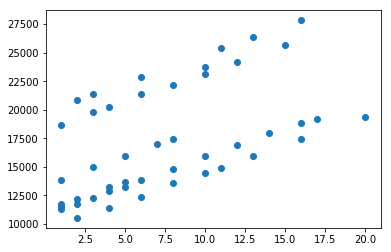

In [47]:
plt.plot(data['X'], data['S'], 'o')

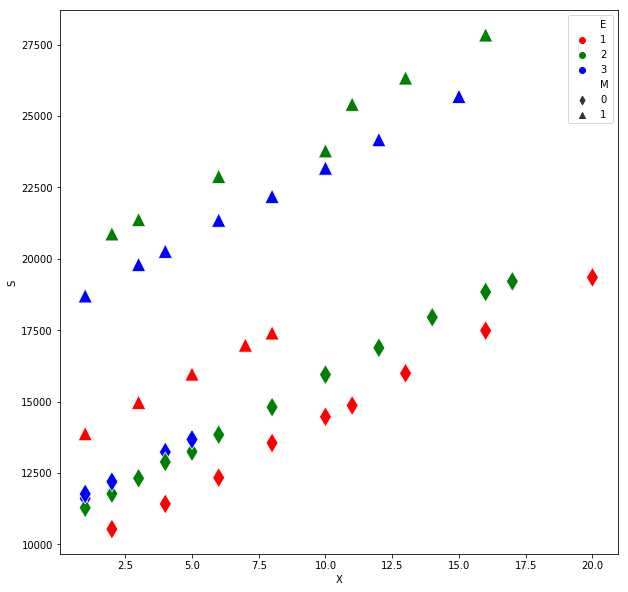

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
sn.scatterplot(
    'X',
    'S',
    data=data,
    hue='E',
    alpha=1,
    style='M',
    cmap='rainbow',
    palette=['r', 'g', 'b'],
    ax=ax,
    s=200,
    markers=['d', '^'],
)

----
### Modelling Data

It appears visually that each set of points (i.e. for a given E, M combination) lies on a straight line, with common slope.

To test this, we first create variables that mimic the effect of E being a category.  Although E appears to be  a numeric value, it is really categorical, and so we define a variable E2 that is 1 if the employee has a Masters, and zero otherwise (and similarly for Ph D.s).  The ```M``` variable is already in this form, as there are only two levels of Management status.

In [49]:
data2 = data.copy()
data2['E2'] = [1 if e == 2 else 0 for e in data['E']]
data2['E3'] = [1 if e == 3 else 0 for e in data['E']]

We specify a model where the Salary (S), depend linearly in Experience (X), Education level (E2, E3), and Management Status (M).  As E2, E3, and M are either 0 or 1, they just move the line of common slope (Salary vs Experience) up or down.

In [50]:
res = ols('S ~ X + M + E2 + E3', data2).fit()

In [51]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     226.8
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           2.23e-27
Time:                        16:35:07   Log-Likelihood:                -381.63
No. Observations:                  46   AIC:                             773.3
Df Residuals:                      41   BIC:                             782.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8035.5976    386.689     20.781      0.000    7254.663    8816.532
X            546.1840     30.519     17.896      0.000     484.549     607.819
M           6883.5310    313.919     21.928      0.000    6249.559    7517.503
E2          3144.0352    361.968      8.686      0.000    2413.025    3875.045
E3          2996.2103    411.753      7.277      0.000    2164.659    3827.762
==============================================================================
Omnibus:                        2.293   Durbin-Watson:                   2.237
Prob(Omnibus):                  0.318   Jarque-Bera (JB):                1.362
Skew:                          -0.077   Prob(JB):                        0.506
Kurtosis:                       2.171   Cond. No.                         33.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

----

### Using Pandas and OLS Together

Another way of doing this is to use ```pandas``` support for categorical variables.  If we declare to ```pandas``` that Education (E) is a categorical variable, then the ```statsmodels``` OLS fitting will automatically create the extra variables for us as below (note, all values in the OLS results are the same)

Define E to be a ```pandas``` category

In [52]:
data['E'] = data['E'].astype('category')

In [53]:
data.head()

,S,X,E,M
0,13876,1,1,1
1,11608,1,3,0
2,18701,1,3,1
3,11283,1,2,0
4,11767,1,3,0


In [54]:
data.dtypes

S       int64
X       int64
E    category
M       int64
dtype: object

In [55]:
res = ols('S ~ X + M + E', data).fit()

In [56]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     226.8
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           2.23e-27
Time:                        16:35:08   Log-Likelihood:                -381.63
No. Observations:                  46   AIC:                             773.3
Df Residuals:                      41   BIC:                             782.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8035.5976    386.689     20.781      0.000    7254.663    8816.532
E[T.2]      3144.0352    361.968      8.686      0.000    2413.025    3875.045
E[T.3]      2996.2103    411.753      7.277      0.000    2164.659    3827.762
X            546.1840     30.519     17.896      0.000     484.549     607.819
M           6883.5310    313.919     21.928      0.000    6249.559    7517.503
==============================================================================
Omnibus:                        2.293   Durbin-Watson:                   2.237
Prob(Omnibus):                  0.318   Jarque-Bera (JB):                1.362
Skew:                          -0.077   Prob(JB):                        0.506
Kurtosis:                       2.171   Cond. No.                         33.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-----
### Assessing the Model

Below, we generate a quick and easy plot of the actual values of Salary, and the predicted values.  It appears we got the slope right, but the predicted offset for the line within each E, M group is not so good.

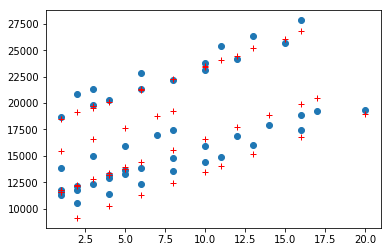

In [57]:
plt.plot(data['X'], data['S'], 'o')
plt.plot(data['X'], res.predict(), 'r+')

### Detailed Visualization of Residuals

We generate some more detailed graphics showing predicted against actuals.  To do this, we have to extendd our DataFrame to include the predicted values

We first show the predicted points (P=1) (small markers = predicted, large markers = actuals). 

Then we visualize the fit of the estimated line to the actuals

In [58]:
data3 = data.copy()
data3['S'] = res.predict()
data3['P'] = [1] * len(data3)

In [59]:
data2 = data.copy()
data2['P'] = [0] * len(data2)

In [60]:
data4 = pd.concat([data2, data3])

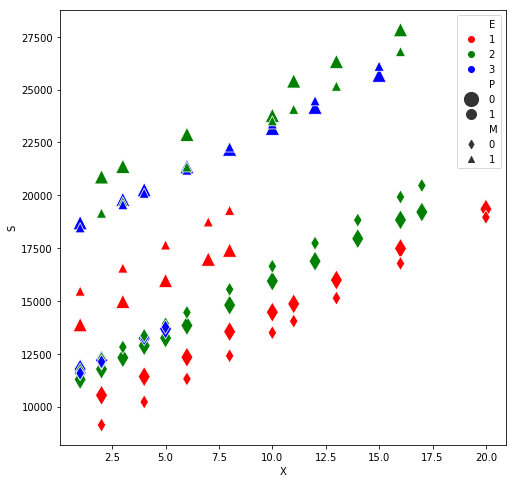

In [61]:
fig, ax = plt.subplots(figsize=(8, 8))
sn.scatterplot(
    'X',
    'S',
    data=data4,
    hue='E',
    alpha=1,
    style='M',
    size='P',
    cmap='rainbow',
    palette=['r', 'g', 'b'],
    ax=ax,
    sizes=[200, 100],
    markers=['d', '^'],
)

We visualize estimated lines against actual Salary values

In [62]:
data7 = data.copy()
#  compute group for data points (3 education levels * 2 management levels)
data7['G'] = [
    2 * e - 1 + m for e, m in zip(data['E'], data['M'])
]

Compute the predicted lines for each (E, M) group

In [63]:
data['P'] = res.predict()
cols = ['r', 'g', 'b']
x = []
y = []
c = []
for i in range(1, 7):
    x.append(list(data[data7['G'] == i]['X']))
    y.append(list(data[data7['G'] == i]['P']))
    icol = (i + 1) // 2
    c.append(cols[icol - 1])
# endif

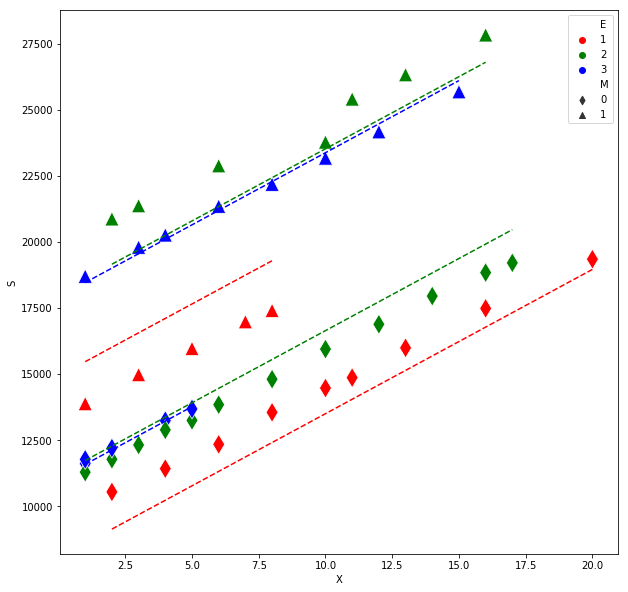

In [64]:
fig, ax = plt.subplots(figsize=(10, 10))
sn.scatterplot(
    'X',
    'S',
    data=data,
    hue='E',
    alpha=1,
    style='M',
    cmap='rainbow',
    palette=['r', 'g', 'b'],
    ax=ax,
    s=200,
    markers=['d', '^'],
)
for xx, yy, col in zip(x, y, c):
    ax.plot(xx, yy, col + '--')
# end for

We do a quick and easy plot of the residuals against Experience (X)

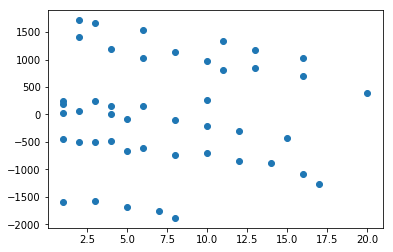

In [65]:
plt.plot(data['X'], res.resid, 'o')

#### Conclusions

It is clear that our model could be improved (even though R^2 is quite close to 1.0) 

----
## Include Interactions *Between* Input Variables

We now move on to models that include interactions between input variables

### Education and Experience Interaction

First test if Education Level (E) changes how Experience (X) is valued  (i.e. the slope of Salary against Experience changes depending upon the Education level)

In [85]:
res2 = ols('S ~ E + M + X + X:E', data).fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     158.6
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           8.23e-26
Time:                        17:18:44   Log-Likelihood:                -379.47
No. Observations:                  46   AIC:                             772.9
Df Residuals:                      39   BIC:                             785.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7256.2800    549.494     13.205      0.000    6144.824    8367.736
E[T.2]      4172.5045    674.966      6.182      0.000    2807.256    5537.753
E[T.3]      3946.3649    686.693      5.747      0.000    2557.396    5335.333
M           7102.4539    333.442     21.300      0.000    6428.005    7776.903
X            632.2878     53.185     11.888      0.000     524.710     739.865
X:E[T.2]    -125.5147     69.863     -1.797      0.080    -266.826      15.796
X:E[T.3]    -141.2741     89.281     -1.582      0.122    -321.861      39.313
==============================================================================
Omnibus:                        0.432   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.806   Jarque-Bera (JB):                0.590
Skew:                           0.144   Prob(JB):                        0.744
Kurtosis:                       2.526   Cond. No.                         69.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can test is the new model explains more of the variance:  it appears to, but not at a significant level  ( we might such improvment 15 time out of 100, by random chance).

Note that we have to wrap our ```anova_lm``` call to supress some supurious messages


In [89]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    anv = sm.stats.anova_lm(res, res2)
# end with
anv

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,41.0,4.328072e+07,0.0,NaN,NaN,NaN
1,39.0,3.941068e+07,2.0,3.870040e+06,1.914856,0.160964


We visualize how the residuals behave with this model

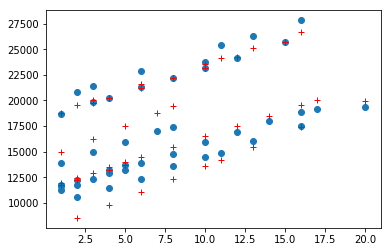

In [90]:
plt.plot(data['X'], data['S'], 'o')
plt.plot(data['X'], res2.predict(), 'r+')

As before, we define a pandas column that is the group (E, M combination) the observation belongs to.  We then use this in Seaborn, to show the distribution of residuals within each group

In [91]:
data4 = data.copy()
data4['R'] = res2.resid
data4['G'] = [
    2 * e - 1 + m for e, m in zip(data['E'], data['M'])
]

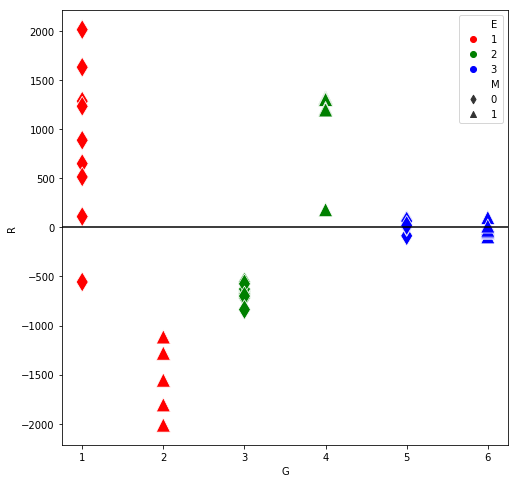

In [92]:
fig, ax = plt.subplots(figsize=(8, 8))
sn.scatterplot(
    'G',
    'R',
    data=data4,
    hue='E',
    alpha=1,
    style='M',
    cmap='rainbow',
    palette=['r', 'g', 'b'],
    ax=ax,
    s=200,
    markers=['d', '^'],
)
ax.axhline(0.0, color='k')

Define a column ```G``` giving a group number for each (E, M) combination

In [93]:
data7 = data.copy()

data7['G'] = [
    2 * e - 1 + m for e, m in zip(data['E'], data['M'])
]

Define arrays holding the predicted salary for each observation within each group.  ```c``` holds the color of the line to draw

In [94]:
data['P'] = res2.predict()
cols = ['r', 'g', 'b']
x = []
y = []
c = []
for i in range(1, 7):
    x.append(list(data[data7['G'] == i]['X']))
    y.append(list(data[data7['G'] == i]['P']))
    icol = (i + 1) // 2
    c.append(cols[icol - 1])
# endif

Use Seaborn to plot the lines of predicted Salary vs Experience, for each group

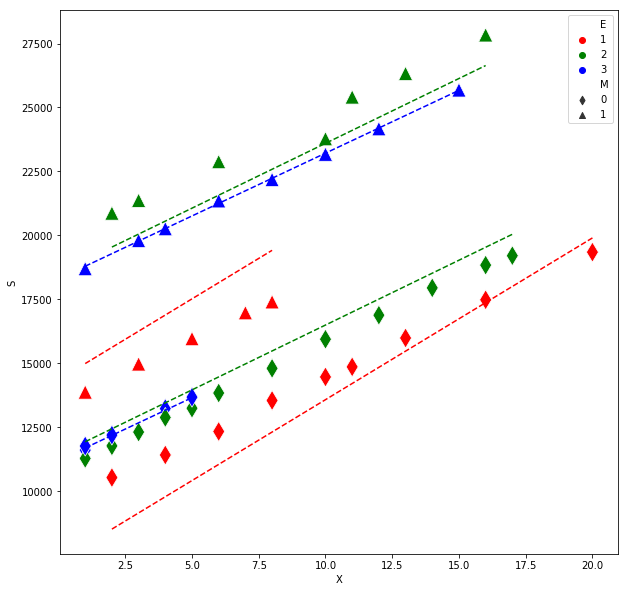

In [95]:
fig, ax = plt.subplots(figsize=(10, 10))
sn.scatterplot(
    'X',
    'S',
    data=data,
    hue='E',
    alpha=1,
    style='M',
    cmap='rainbow',
    palette=['r', 'g', 'b'],
    ax=ax,
    s=200,
    markers=['d', '^'],
)
for xx, yy, col in zip(x, y, c):
    ax.plot(xx, yy, col + '--')
# end for

We can see that our model has produced lines of different slope (Salary vs Experience) as expected, but there still seem to be non-random, systematic error is our predictions.


We can visualize this via an Interaction Plot, showing the effect both Education and Management Status have on the average of the residuals (which should be zero)

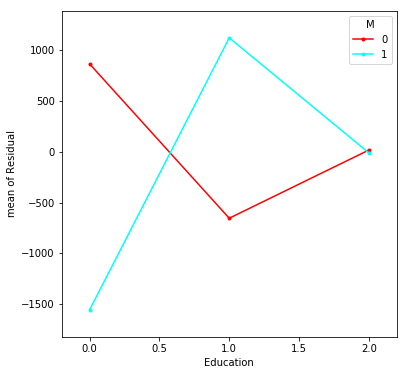

In [99]:
fig, ax = plt.subplots(figsize=(6, 6))

sm.graphics.interaction_plot(
    data['E'],
    data['M'],
    res2.resid,
    ax=ax,
    xlabel='Education',
    ylabel='Residual',
)
plt.show()

-----

###  Education and Management Interaction

In our next model, we test if there is an interaction between Education Level (E) and Management Status (M).  If we look at the original data plot at the top, we notice that in management  staff (unlike operational staff),   a Ph D is *not* valued higher than a Masters, so we should expect some interaction  here.

We build a linear model as before, but also adding Education and Management Status interactions.  ```beta-5``` and ```beta-6``` will be zero under the Null Hypothesis (H0) that there is no Education * Management Status interaction


$$\begin{aligned}
   S_i &= \beta_0 + \beta_1 X_i + \beta_2 E_{i2} + \beta_3 E_{i3} +\
\beta_4 M_i \\
   & \qquad  + \beta_5 E_{i2} M_i + \beta_6 E_{i3} M_i + \varepsilon_i.
   \end{aligned}$$

In [100]:
res3 = ols('S ~ X + E + M + E:M', data=data).fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5517.
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           1.67e-55
Time:                        18:50:30   Log-Likelihood:                -298.74
No. Observations:                  46   AIC:                             611.5
Df Residuals:                      39   BIC:                             624.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9472.6854     80.344    117.902      0.000    9310.175    9635.196
E[T.2]      1381.6706     77.319     17.870      0.000    1225.279    1538.063
E[T.3]      1730.7483    105.334     16.431      0.000    1517.690    1943.806
X            496.9870      5.566     89.283      0.000     485.728     508.246
M           3981.3769    101.175     39.351      0.000    3776.732    4186.022
E[T.2]:M    4902.5231    131.359     37.322      0.000    4636.825    5168.222
E[T.3]:M    3066.0351    149.330     20.532      0.000    2763.986    3368.084
==============================================================================
Omnibus:                       74.761   Durbin-Watson:                   2.244
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1037.873
Skew:                          -4.103   Prob(JB):                    4.25e-226
Kurtosis:                      24.776   Cond. No.                         79.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We find that we must reject the Hypothesis that all coefficients are zero.  

We now check to see if significantly more variance is explained; we find that it is

In [101]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    anv = sm.stats.anova_lm(res, res3)
# end with
anv

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,41.0,4.328072e+07,0.0,NaN,NaN,NaN
1,39.0,1.178168e+06,2.0,4.210255e+07,696.844466,3.025504e-31


As before, we now plot our residuals, by group, and also by Experience (X)

In [103]:
data5 = data.copy()
data5['R'] = res3.resid
data5['G'] = [
    2 * e - 1 + m for e, m in zip(data['E'], data['M'])
]

Residuals plotted for each group

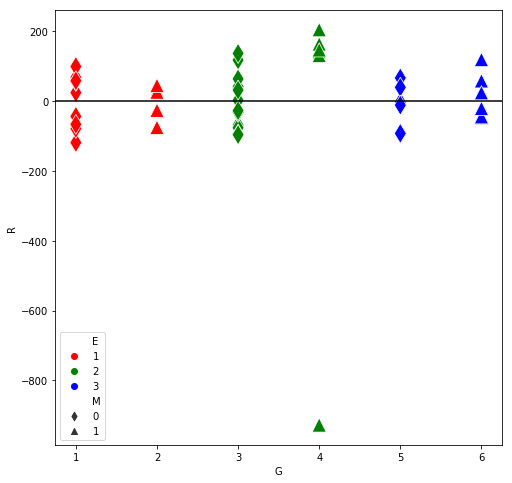

In [105]:
fig, ax = plt.subplots(figsize=(8, 8))
sn.scatterplot(
    'G',
    'R',
    data=data5,
    hue='E',
    alpha=1,
    style='M',
    cmap='rainbow',
    palette=['r', 'g', 'b'],
    ax=ax,
    s=200,
    markers=['d', '^'],
)
ax.axhline(0.0, color='k')

Residuals plotted by Experience (X)

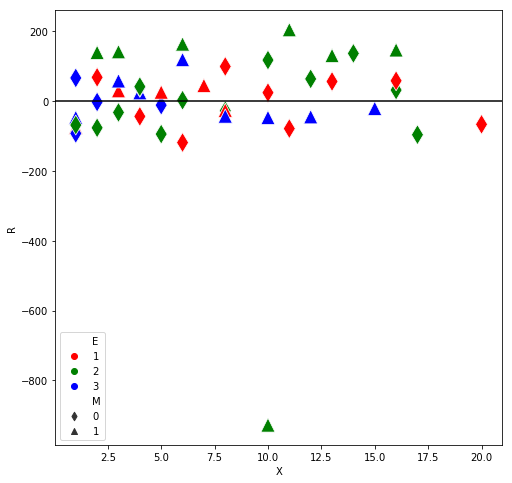

In [106]:
fig, ax = plt.subplots(figsize=(8, 8))
sn.scatterplot(
    'X',
    'R',
    data=data5,
    hue='E',
    alpha=1,
    style='M',
    cmap='rainbow',
    palette=['r', 'g', 'b'],
    ax=ax,
    s=200,
    markers=['d', '^'],
)
ax.axhline(0.0, color='k')

We clearly have a single outlier.  We identify this observation

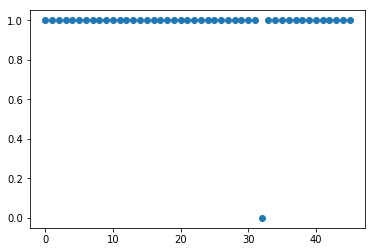

In [110]:
res3_outlier = res3.outlier_test()
_ = plt.plot(
    range(len(res3.resid)), res3_outlier['bonf(p)'], 'o'
)

In [112]:
data[res3_outlier['bonf(p)'] < 0.8][['S', 'X', 'E', 'M']]

,S,X,E,M
32,23780,10,2,1


Check it is the bad value (it is)

In [115]:
print(f'Residual of Outlier = {res3.resid[32]}')

Residual of Outlier = -928.126156475384


Drop the bad row, and re-do our two models (original pure linear, and linear plus E x M interactions)

In [116]:
data_clean = data.drop([32]).copy()

In [117]:
res_clean = ols('S ~ E + X + M', data=data_clean).fit()
res_clean3 = ols(
    'S ~ E + X + M + E:M', data=data_clean
).fit()

We test if the improved explanation of variance in the second model could be by chance (No, it is not, to a very high degree of certainity)

In [118]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    anv = sm.stats.anova_lm(res_clean, res_clean3)
# end with
anv

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,40.0,4.320910e+07,0.0,NaN,NaN,NaN
1,38.0,1.711881e+05,2.0,4.303791e+07,4776.734853,2.291239e-46


In [119]:
res_clean3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.543e+04
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           1.30e-69
Time:                        20:31:39   Log-Likelihood:                -249.34
No. Observations:                  45   AIC:                             512.7
Df Residuals:                      38   BIC:                             525.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9458.3778     31.041    304.709      0.000    9395.539    9521.216
E[T.2]      1384.2937     29.858     46.362      0.000    1323.849    1444.739
E[T.3]      1741.3359     40.683     42.803      0.000    1658.979    1823.693
X            498.4178      2.152    231.640      0.000     494.062     502.774
M           3988.8169     39.073    102.085      0.000    3909.717    4067.917
E[T.2]:M    5049.2939     51.668     97.727      0.000    4944.699    5153.889
E[T.3]:M    3051.7633     57.674     52.914      0.000    2935.008    3168.519
==============================================================================
Omnibus:                        1.462   Durbin-Watson:                   2.438
Prob(Omnibus):                  0.482   Jarque-Bera (JB):                1.171
Skew:                           0.177   Prob(JB):                        0.557
Kurtosis:                       2.293   Cond. No.                         78.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We plot the predicted vs actuals

Now we get a lot better fit between predicted and actuals 

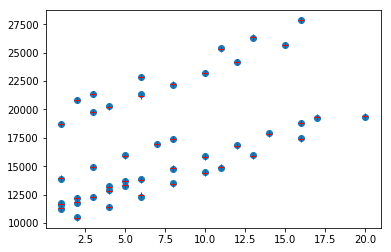

In [120]:
plt.plot(data_clean['X'], data_clean['S'], 'o')
plt.plot(data_clean['X'], res_clean3.predict(), 'r+')

We plot the linear components of our model

In [122]:
data4 = data_clean.copy()

data4['G'] = [
    2 * e - 1 + m
    for e, m in zip(data_clean['E'], data_clean['M'])
]

In [123]:
data_clean['P'] = res_clean3.predict()
cols = ['r', 'g', 'b']
x = []
y = []
c = []
for i in range(1, 7):
    x.append(list(data_clean[data4['G'] == i]['X']))
    y.append(list(data_clean[data4['G'] == i]['P']))
    icol = (i + 1) // 2
    c.append(cols[icol - 1])
# endif

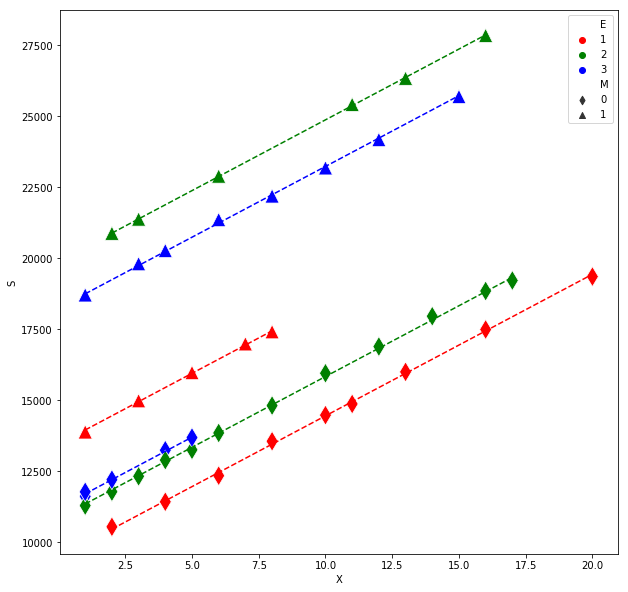

In [124]:
fig, ax = plt.subplots(figsize=(10, 10))
sn.scatterplot(
    'X',
    'S',
    data=data_clean,
    hue='E',
    alpha=1,
    style='M',
    cmap='rainbow',
    palette=['r', 'g', 'b'],
    ax=ax,
    s=200,
    markers=['d', '^'],
)
for xx, yy, col in zip(x, y, c):
    ax.plot(xx, yy, col + '--')
# end for

The plot of standardized residuals shows that they look as random as we would expect from our model

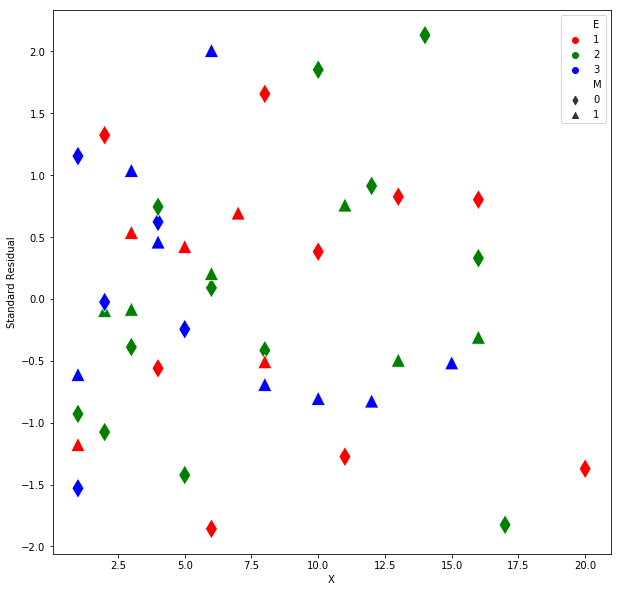

In [127]:
data_clean['Standard Residual'] = res_clean3.outlier_test()[
    'student_resid'
]

fig, ax = plt.subplots(figsize=(10, 10))
sn.scatterplot(
    'X',
    'Standard Residual',
    data=data_clean,
    hue='E',
    alpha=1,
    style='M',
    cmap='rainbow',
    palette=['r', 'g', 'b'],
    ax=ax,
    s=200,
    markers=['d', '^'],
)

If we display the interaction plot, using Salary adjusted for Experience (i.e. just leaving the effect of Magagement Status and Education, we can see that a Ph D is valued less that a Master (unlike in operational staff).

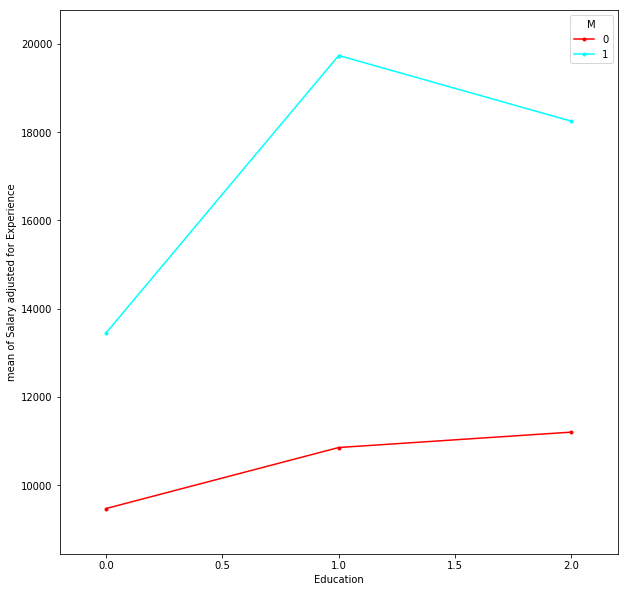

In [364]:
fig, ax = plt.subplots(figsize=(10, 10))
U = data_clean['S'] - data_clean['X'] * res_clean3.params['X']
sm.graphics.interaction_plot(
    data_clean['E'],
    data_clean['M'],
    U,
    ax=ax,
    xlabel='Education',
    ylabel='Salary adjusted for Experience',
)
plt.show()

### Residual Comparison

Finally, we can compre the residuals for both models in the one graph.  The second model is clearly superior

Text(0, 0.5, 'Residual (Actual-Predicted)')

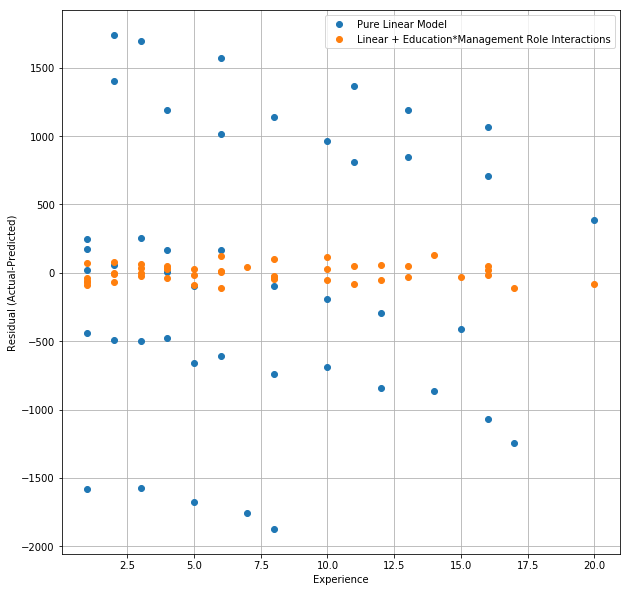

In [128]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(
    data_clean['X'],
    res_clean.resid,
    'o',
    label='Pure Linear Model',
)
ax.plot(
    data_clean['X'],
    res_clean3.resid,
    'o',
    label='Linear + Education*Management Role Interactions',
)
ax.grid()
ax.legend(loc='best')
ax.set_xlabel('Experience')
ax.set_ylabel('Residual (Actual-Predicted)')

-----------
## Environment



In [129]:
%watermark -h -iv
%watermark

seaborn     0.9.0
scipy       1.1.0
statsmodels 0.9.0
pandas      1.0.0
matplotlib  3.0.2
numpy       1.15.4
host name: DESKTOP-SODFUN6
2020-03-25T20:55:50+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
